In [1]:
import pandas as pd 

train_data = pd.read_csv("/Users/dhanalakshmijothi/Desktop/Kaggle/russian-car-plates-prices-prediction/train.csv")
test_data = pd.read_csv("/Users/dhanalakshmijothi/Desktop/Kaggle/russian-car-plates-prices-prediction/test.csv")

print(train_data.head())
print(test_data.head())

   id      plate                 date   price
0   1  X059CP797  2024-12-26 00:00:00   65000
1   2  Y800MH790  2024-07-12 21:31:37  100000
2   3   A212TX77  2024-04-18 00:00:00  290000
3   4  P001AY199  2025-01-03 00:27:15  680000
4   5  P001AY199  2025-01-10 09:32:41  750000
      id      plate                 date  price
0  51636  P700TT790  2025-01-27 00:00:00    NaN
1  51637  M081TX797  2025-02-10 00:00:00    NaN
2  51638  T333HX777  2025-02-11 00:00:00    NaN
3  51639  H744BH977  2025-02-03 00:00:00    NaN
4  51640  X066EM777  2025-02-12 00:00:00    NaN


In [2]:
missing_values = train_data.isnull().sum()
print(missing_values)

outlier = train_data.describe()
print(outlier)

id       0
plate    0
date     0
price    0
dtype: int64
                 id         price
count  51635.000000  5.163500e+04
mean   25818.000000  4.532253e+05
std    14905.884912  1.793287e+06
min        1.000000  2.000000e+04
25%    12909.500000  7.000000e+04
50%    25818.000000  1.500000e+05
75%    38726.500000  3.600000e+05
max    51635.000000  1.000000e+08


In [17]:
import numpy as np

train_data['region_code'] = train_data['plate'].str[6:]
test_data['region_code'] = test_data['plate'].str[6:]

train_data['region_code_letters'] = train_data['plate'].str[:3]
test_data['region_code_letters'] = test_data['plate'].str[:3]

train_data['date'] = pd.to_datetime(train_data['date'])
train_data['only_date'] = train_data['date'].dt.date
train_data['only_time'] = train_data['date'].dt.time
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['only_date'] = test_data['date'].dt.date
test_data['only_time'] = test_data['date'].dt.time

train_data['log_price'] = np.log1p(train_data['price'])

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

train_data['region_code'] = encoder.fit_transform(train_data['region_code'])
test_data['region_code'] = encoder.transform(test_data['region_code'])

train_data['region_code_letters'] = encoder.fit_transform(train_data['region_code_letters'])
test_data['region_code_letters'] = encoder.transform(test_data['region_code_letters'])

train_data['only_date'] = pd.to_datetime(train_data['only_date'])
test_data['only_date'] = pd.to_datetime(test_data['only_date'])

# Extract features from date
train_data['year'] = train_data['only_date'].dt.year
train_data['month'] = train_data['only_date'].dt.month
train_data['day'] = train_data['only_date'].dt.day
test_data['year'] = test_data['only_date'].dt.year
test_data['month'] = test_data['only_date'].dt.month
test_data['day'] = test_data['only_date'].dt.day

In [31]:
from sklearn.preprocessing import OneHotEncoder

X = train_data.drop(columns = ['id', 'plate', 'date', 'price', 'log_price', 'only_time', 'only_date'])
Y = train_data['log_price']
X_test = test_data.drop(columns= ['id', 'plate', 'date', 'price', 'only_time', 'only_date'])

from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)

import xgboost as xgb

base_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 200, max_depth = 5)
base_model.fit(X_train, Y_train)

train_pred = base_model.predict(X_train)
X_valid_pred = base_model.predict(X_valid)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y_valid, X_valid_pred)

print(f'MSE on validation set: {mse:.4f}')

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(base_model, X, Y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validation scores: {cv_scores}')


MSE on validation set: 0.7632
Cross-validation scores: [-0.78778254 -0.79658428 -0.80534746 -0.78713955 -0.80438907]


MSE on metamodel validation set: 0.7702
Validation SMAPE: 5.393798369738482


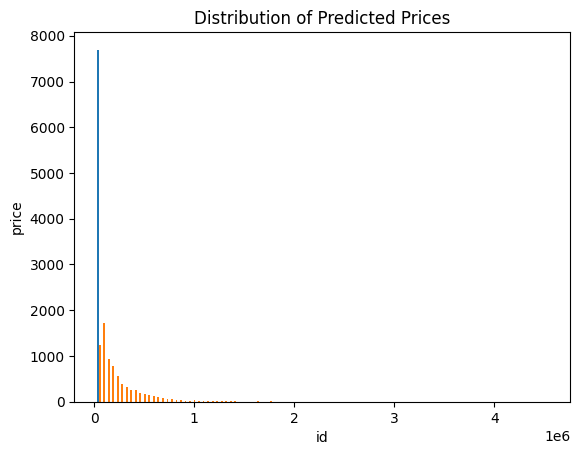

Submission file created successfully.


In [38]:
from sklearn.linear_model import LinearRegression

meta_model = LinearRegression()
meta_model.fit(train_pred.reshape(-1,1), Y_train)

meta_model_pred = meta_model.predict(X_valid_pred.reshape(-1,1))

mse = mean_squared_error(Y_valid, meta_model_pred)
print(f'MSE on metamodel validation set: {mse:.4f}')

# Calculate SMAPE for validation set
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(numerator / denominator)

# Calculate SMAPE on validation predictions
smape_score = smape(Y_valid, meta_model_pred)
print(f'Validation SMAPE: {smape_score}')

test_data_pred = base_model.predict(X_test)
final_pred = meta_model.predict(test_data_pred.reshape(-1,1))

final_pred = np.expm1(final_pred)

submission = pd.DataFrame({
    'id': test_data['id'],
    'price' : final_pred
})

import matplotlib.pyplot as plt 

plt.hist(submission, bins=100)
plt.title("Distribution of Predicted Prices")
plt.xlabel("id")
plt.ylabel("price")
plt.savefig("/Users/dhanalakshmijothi/Desktop/Kaggle/russian-car-plates-prices-prediction/predicted_price_distribution.jpg", dpi = 300, bbox_inches = 'tight')
plt.show()

submission.to_csv('/Users/dhanalakshmijothi/Desktop/Kaggle/russian-car-plates-prices-prediction/submission.csv', index=False)

print('Submission file created successfully.')